# Summarise your favourite podcasts before listening using Amazon Bedrock, Anthropic Claude LLM and Amazon Transcribe

## Introduction

In this notebook we will explore using Amazon Bedrock to generate a concise yet meaningful summary of a podcast. We will explore the art of possibility with the Amazon Bedrock and using one of the foundational large-language models (LLM). This Notebook is a companion guide to the blog post [link]() and the steps are explained in detail in the blog post.

## Solution Architecture

Let us look at the Solution Architecture for the demo setup.

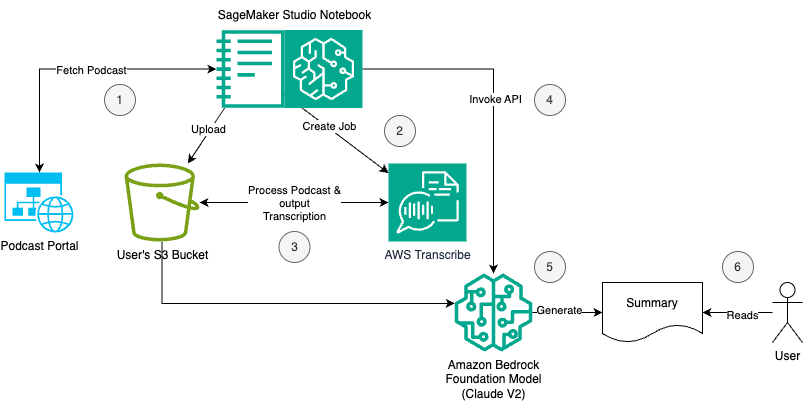

Steps:
1. Using SageMaker Studio Notebook, the podcast is fetched from the podcast source and uploaded to an S3 bucket. For this demo, the S3 bucket, the folders are created as part of prerequisites as explained in the blog post.
2. A Transcribe job is created using Amazon Transcribe API to automatically convert speech to text. Amazon Transcribe is an AWS AI service that automatically converts speech to text. 
3. The output of successful completion of the job is a JSON file that contains the text extracted from the podcast file. The JSON file is stored in the same S3 bucket under 'out' folder.
4. The output JSON file is read and the text is extracted in the Studio Notebook instance's memory. An instance of Anthropic Claude V2 model is created using Amazon Bedrock API.
5. Using prompt engineering, the model is instructed to summarise the extracted podcast text and list the output in bullet points.
6. User reads the LLM model’s response, which is a richer, deeper and meaningful summary of the podcast. If needed, user can modify the prompt to derive a longer or more concise summary by tuning the model's inference parameters.

## Demo steps

Install the prerequisite libraries

In [ ]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

%pip install langchain==0.0.309 "transformers>=4.24,<5"

%pip install tiktoken

Fetch the podcast mp3 file and save it in the Notebook instance's local folder.

In [ ]:
!wget -O podcast.mp3 http://www.brown.edu/Departments/Watson_Institute/Open_Source/RadioOpenSource-Harold_Bloom-Melville.mp3

Upload the podcast in to an existing S3 bucket. The upload_file API uploads the podcast.mp3 file in to the specified S3 folder.

In [164]:
import boto3

s3_client = boto3.client('s3')
file_name = "podcast.mp3"
bucket = "calicul-ug-2023"
object_name = "transcribe/in/podcast.mp3"
response = s3_client.upload_file(file_name, bucket, object_name)

In [183]:
import json
import os
import sys
import sagemaker
import time
import json
import warnings
import langchain
import tiktoken
warnings.filterwarnings('ignore')

Get the session's execution role, nativate to IAM role and check whether the role has the relevant permissions to access Bedrock, S3, Transcribe. For this demo, I have assigned admin role to the session role but from a least-privilege principle, only the necessary permissions should be provided. Refer to Identity-based policy examples for [Bedrock](https://docs.aws.amazon.com/bedrock/latest/userguide/security_iam_id-based-policy-examples.html) for additional details on setting least-privilege permissions.  

In [ ]:
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
role

Start a Transcribe job.

In [168]:
transcribe = boto3.client('transcribe')

job_name = "transcribe_podcast"
job_uri = "s3://calicul-ug-2023/transcribe/in/podcast.mp3"
output_job_uri = "calicul-ug-2023"
output_loc = "transcribe/out/"
response = transcribe.start_transcription_job( 
    TranscriptionJobName=job_name,
    Media={'MediaFileUri': job_uri},
    OutputBucketName=output_job_uri,
    OutputKey=output_loc,
    MediaFormat='mp3',
    LanguageCode='en-US')

Await for the Transcribe job to be completed. If the job succeeds or fails, exit. If not, keep querying the Transcribe job status API for a maximum of 600 seconds.

In [169]:
max_tries = 60
while max_tries > 0:
    max_tries -= 1
    job = transcribe.get_transcription_job(TranscriptionJobName=job_name)
    job_status = job['TranscriptionJob']['TranscriptionJobStatus']
    if job_status in ['COMPLETED', 'FAILED']:
        print(f"Job {job_name} is {job_status}.")
        if job_status == 'COMPLETED':
            print(
                f"Download the transcript from\n"
                f"\t{job['TranscriptionJob']['Transcript']['TranscriptFileUri']}.")
        break
    else:
        print(f"Waiting for {job_name}. Current status is {job_status}.")
    time.sleep(10)

Waiting for transcribe_podcast. Current status is IN_PROGRESS.
Waiting for transcribe_podcast. Current status is IN_PROGRESS.
Waiting for transcribe_podcast. Current status is IN_PROGRESS.


Fetch the transcribe output JSON file and load the output in the instance's memory.

In [187]:
s3 = boto3.client('s3')
bucket = 'calicul-ug-2023'
key = 'transcribe/out/transcribe_podcast.json'
response = s3.get_object(Bucket=bucket, Key=key)
data = json.loads(response['Body'].read().decode('utf-8'))
text = data['results']['transcripts'][0]['transcript']
print(data['results']['transcripts'][0]['transcript'][:500])
#text

I'm Christopher Lydon, heading into Harold Bloom's class at Yale on the American masterpiece, Moby Dick. This is open source from the Watson Institute at Brown University, an American conversation with global attitude. We call it Harold. It's amazing to me. We've never talked about the Great Melville or the Great Moby Dick on the way to class said it in your blooming framework. Well, there won't be time to talk to the Children about this today because I want them to read out loud from Moby Dick.


In [ ]:
bedrock = boto3.client(service_name='bedrock-runtime')
from langchain.llms.bedrock import Bedrock

llm = Bedrock(
    model_id="anthropic.claude-v2",
    model_kwargs={
        "maxTokenCount": 8191,
        "stopSequences": [],
        "temperature": 0,
        "topP": 1,
    },
    client=bedrock,
)

llm.get_num_tokens(text)

Get the number of Tokens embedded in the text output of Transcribe job. Use [tiktoken library](https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb) to get the Token count.

In [186]:
encoding = tiktoken.get_encoding('cl100k_base')
num_tokens = len(encoding.encode(text))
num_tokens

5584

Since we have around five thousand token, we need to choose an LLM model with a sufficient context window. Reviewing the documentation related to the inference parameters for the supported foundational models, we can see that Anthropic Claude LLM has a 100K long context window. We find that Anthropic Claude V2 LLM model with a 100K context window (75,000 words) will be sufficient for our summarisation task. Pass the prompt body to the Claude V2 LLM model and wait for a response. It takes about 30-40 seconds for the model to return the response.

In [172]:
prompt = "\n\nHuman:Summarize the following text in a concise manner. Limit the response to 1000 words. Write the response in bullet points. \n\n"""+ text + "\n\nAssistant:"
body = json.dumps({
    "prompt": prompt,
    "max_tokens_to_sample": 1500,
    "temperature": 0.1,
    "top_p": 0.5
})

#print(body)

In [173]:
modelId = 'anthropic.claude-v2'
accept = 'application/json'
contentType = 'application/json'

bedrock = boto3.client(service_name='bedrock-runtime')
response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)

response_body = json.loads(response.get('body').read())
# text
print(response_body.get('completion'))

 Here is a summary of the key points from the text in bullet points:

- Harold Bloom considers Herman Melville and Walt Whitman to be the two greatest figures in American literature. He sees Moby Dick as an almost flawless "prose epic" on par with the best of Shakespeare. 

- Ishmael is the biblical name of Abraham's disinherited son, indicating Melville's humorous bitterness at his own family's fallen status. Ishmael is an unreliable narrator who sometimes vanishes from the story.

- Captain Ahab represents defiance against God's tyranny over nature and humanity. His obsession with vengeance on the white whale echoes the biblical King Ahab's conflicts with the prophet Elijah.

- The white whale symbolizes the blankness or meaninglessness of nature and the universe. This trope of whiteness haunts much of American literature.

- Though the whalers are Quakers, the hunt seems unfair and horrifying. There is an inverse ratio between the trope of whiteness and the paradox of these "killers

In [176]:
prompt = "Human:List the top 3 characters in the text and explain their role. \\n\\n"+ text + "\\n\\nAssistant:"
body = json.dumps({
    "prompt": prompt,
    "max_tokens_to_sample": 1500,
    "temperature": 0,
    "top_p": 0.99
})

In [177]:
modelId = 'anthropic.claude-v2'
accept = 'application/json'
contentType = 'application/json'

response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)

response_body = json.loads(response.get('body').read())
# text
print(response_body.get('completion'))

 Here are the top 3 characters in Moby Dick and their roles:

1. Captain Ahab - The monomaniacal captain of the Pequod who is obsessed with getting revenge on the white whale Moby Dick that bit off his leg. He is driven by vengeance and his quest consumes him. 

2. Ishmael - The narrator of the story. He signs up for a whaling voyage on the Pequod to escape his depression and melancholy. He is philosophical and reflective. As the sole survivor of the voyage, he lives to tell the tale.

3. Moby Dick - The great white whale that is the object of Captain Ahab's vengeance. While a literal whale, he also serves as a symbol of nature, the mysteries of the universe, evil, and more. His whiteness and elusiveness maddens Ahab.

In summary, Ahab is the crazed captain seeking vengeance, Ishmael is the contemplative narrator, and Moby Dick is the whale that drives the plot through the obsessive hunt by Ahab. Their interplay and motivations shape this epic story of man versus nature.


In [188]:
prompt = "Human:Explain Ahab's vengeance against Moby Dick. \\n\\n"+ text + "\\n\\nAssistant:"
body = json.dumps({
    "prompt": prompt,
    "max_tokens_to_sample": 1500,
    "temperature": 0,
    "top_p": 0.99
})

In [189]:
modelId = 'anthropic.claude-v2'
accept = 'application/json'
contentType = 'application/json'

response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)

response_body = json.loads(response.get('body').read())
# text
print(response_body.get('completion'))

 Here are a few key points about Ahab's vengeance against Moby Dick in Herman Melville's novel:

- Ahab is the monomaniacal captain of the whaling ship Pequod. He is obsessed with hunting and killing Moby Dick, the great white whale that bit off his leg in a previous encounter. 

- Moby Dick represents many things to Ahab - the embodiment of evil, a force of nature, an affront to Ahab's power and masculinity. The whale is an inscrutable thing that Ahab must dominate and destroy. 

- Ahab sees Moby Dick as a wall or barrier between himself and full knowledge/truth. By hunting the whale, Ahab believes he can "strike through the mask" of existence and get revenge for his lost leg and shattered identity.

- The pursuit of the whale is like an act of defiance against God, fate, and nature itself for Ahab. He sees Moby Dick as a symbol of the cosmic indifference and cruelty of the universe. 

- Ahab's quest is ultimately doomed and self-destructive. In his rage and madness, he dooms his enti